In [3]:
import re
import os
import time
import pickle
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.sparse
from tqdm import tqdm, tqdm_notebook
from collections import defaultdict, OrderedDict
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, coo_matrix, csc_matrix

### PUT YOUR PATH HERE (mine default is home/username/notebooks)
path_to_data = '../../shared_files/'

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [6]:
import numpy as np
from warnings import warn
from scipy.stats import scoreatpercentile
from scipy.spatial.distance import cdist


from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_random_state, check_is_fitted
from sklearn.preprocessing import StandardScaler

__all__ = ["RapidOutlierDetection"]


class RapidOutlierDetection(BaseEstimator, ClassifierMixin):
    """Unsupervised rapid Outlier Detection through sampling
    Parameters
    ----------
    random_state: a random state, default = None
    scaled : if True, X will be scaled, default = True
    n_samples : int, optional (default=20)
        Number of random samples to be used.
        If n_samples is larger than the number of samples provided,
        a ValueError will be thrown.
    metric : string, default 'euclidean'
        metric used for the distance computation. Any metric 
        from scipy.spatial.distance.cdist can be used.
        See the documentation for scipy.spatial.distance.cdist for details on these
        metrics:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    metric_params : dict, optional (default=None)
        Additional keyword arguments for the metric function.
    contamination : float in (0., 0.5), optional (default=0.05)
        The amount of contamination of the data set, i.e. the proportion
        of outliers in the data set. When fitting this is used to define the
        threshold on the decision function.
    References
    ----------
    .. [1] Mahito Sugiyama, Karsten M. Borgwardt
       'Rapid Distance-Based Outlier Detection via Sampling'
       https://papers.nips.cc/paper/5127-rapid-distance-based-outlier-detection-via-sampling.pdf
    """
    def __init__(self, n_samples=20, metric='euclidean',metric_params=None,random_state=None,scaled=True,
                 contamination=0.05):
        self.n_samples=n_samples
        self.metric=metric
        self.metric_params=metric_params 
        self.random_state=random_state
        self.scaled=scaled
        self.contamination = contamination

    def fit_predict(self, X, y=None):
        """"Fits the model to the training set X and returns the labels
        (1 inlier, -1 outlier) on the training set according to the score
        and the contamination parameter.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features), default=None
            The query sample or samples to compute the score
            w.r.t. to the training samples.
        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns -1 for anomalies/outliers and 1 for inliers.
        """

        return self.fit(X).predict()

    def fit(self, X, y=None):
        """Fit the model using X as training data.
        Parameters
        ----------
        X : {array-like}
            Training data. If array or matrix, shape [n_samples, n_features]
        Returns
        -------
        self : object
            Returns self.
        """
        if not (0. < self.contamination <= .5):
            raise ValueError("contamination must be in (0, 0.5]")

        self.random_state = check_random_state(self.random_state)

        X = check_array(X)
        N, n_features = X.shape
        if self.n_samples > N:
            error = "n_samples = %s, but should be <= %s" % (self.n_samples,N)
            raise ValueError(error)
        if self.n_samples <= 0:
            error = "n_samples = %s, but should be > 0" % self.n_samples
            raise ValueError(error)
        if self.n_samples < 5:
            warning = "n_samples < 5. The method suggests n_samples ~=~ 20."
            warn(warning)
        if self.scaled:
            self.scaler_ = StandardScaler()
            self.scaler_.fit(X)
            X = self.scaler_.transform(X)
        random_indexes = self.random_state.random_integers(0,N-1,self.n_samples)
        X_sampled = X[random_indexes,:]
        

        self.X_sampled_ = X_sampled
        self.X_ = X

        if self.metric_params is None:
            Y = cdist(X,self.X_sampled_,metric=self.metric)
        else:
            Y = cdist(X,self.X_sampled_,metric=self.metric,*self.metric_params)
        scores = np.amin(Y,axis=1)
        self.threshold_ = scoreatpercentile(scores, (1.0-self.contamination)*100.0)



        return self

    def predict(self, X=None):
        """Predict the labels (1 inlier, -1 outlier) of X according to score.
        If X is None, returns the same as fit_predict(X_train).
        This method allows to generalize prediction to new observations (not
        in the training set). 
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features), default=None
            The query sample or samples to compute the score
            w.r.t. to the training samples. If None, makes prediction on the
            training data.
        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns -1 for anomalies/outliers and +1 for inliers.
        """
        if self.scaled:
            check_is_fitted(self, ['X_', 'X_sampled_','threshold_','scaler_'])
        else:
            check_is_fitted(self, ['X_','X_sampled_','threshold_'])
        if X is not None:
            X = check_array(X)
            if self.scaled:
                X = self.scaler_.transform(X)
        else:
            X = self.X_

        if self.metric_params is None:
            Y = cdist(X,self.X_sampled_,metric=self.metric)
        else:
            Y = cdist(X,self.X_sampled_,metric=self.metric,*self.metric_params)
        scores = np.amin(Y,axis=1)
        is_inlier = np.ones(X.shape[0], dtype=int)
        is_inlier[scores >= self.threshold_] = -1

        return is_inlier
    
    def decision_function(self, X=None):
        if self.scaled:
            check_is_fitted(self, ['X_', 'X_sampled_','threshold_','scaler_'])
        else:
            check_is_fitted(self, ['X_','X_sampled_','threshold_'])
        if X is not None:
            X = check_array(X)
            if self.scaled:
                X = self.scaler_.transform(X)
        else:
            X = self.X_

        if self.metric_params is None:
            Y = cdist(X,self.X_sampled_,metric=self.metric)
        else:
            Y = cdist(X,self.X_sampled_,metric=self.metric,*self.metric_params)
        scores = np.amin(Y,axis=1)
        return scores

/home/const.belev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: DeprecationWarning: This function is deprecated. Please call randint(0, 20029 + 1) instead


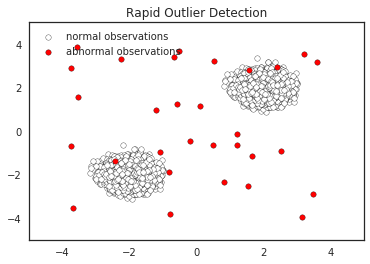

In [4]:
np.random.seed(42)

# Generate train data
N_normal = 10000
X = 0.3 * np.random.randn(N_normal, 2)
# Generate some abnormal novel observations
N_outliers = 30
X_outliers = np.random.uniform(low=-4, high=4, size=(N_outliers, 2))
X = np.r_[X + 2, X - 2, X_outliers]

# fit the model
clf = RapidOutlierDetection(contamination = 1.0*N_outliers/(2.0*N_normal+N_outliers))
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[2*N_normal:]


plt.title("Rapid Outlier Detection")

a = plt.scatter(X[:(2*N_normal), 0], X[:(2*N_normal), 1], c='white',
                edgecolor='k', s=N_outliers)
b = plt.scatter(X[(2*N_normal):, 0], X[(2*N_normal):, 1], c='red',
                edgecolor='k', s=N_outliers)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

In [5]:
xtrain = np.load('xtrain.npy')
xtest = np.load('xtest.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')

In [17]:
try:
    del clf
except:
    pass
clf = RapidOutlierDetection(n_samples=250, contamination = (ytrain == 1).mean())

In [10]:
train_kek, test_kek = np.c_[xtrain[:, -7:-5], xtrain[:, -4:-1]], np.c_[xtest[:, -7:-5], xtest[:, -4:-1]]

In [18]:
clf.fit(train_kek)

/home/const.belev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: DeprecationWarning: This function is deprecated. Please call randint(0, 2292704 + 1) instead


RapidOutlierDetection(contamination=0.01012951949771122, metric='euclidean',
           metric_params=None, n_samples=250,
           random_state=<mtrand.RandomState object at 0x7f5b140929d8>,
           scaled=True)

In [19]:
train_scores = clf.decision_function(train_kek)
test_scores = clf.decision_function(test_kek)

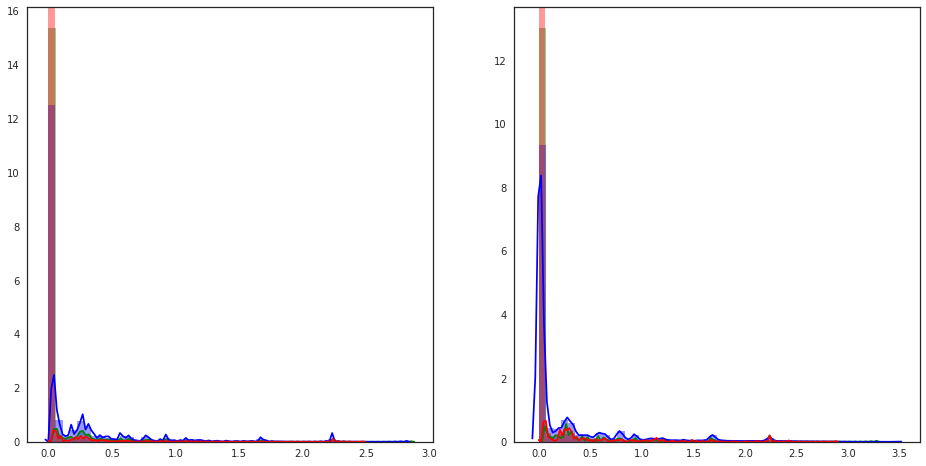

In [20]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
colors = ['g', 'b', 'r']
targets = [-1, 0, 1]
for c, t in zip(colors, targets):
    sns.distplot(np.log1p(train_scores)[ytrain == t], color=c, ax=axes[0])

for c, t in zip(colors, targets):
    sns.distplot(np.log1p(test_scores)[ytest == t], color=c, ax=axes[1])